In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from math import exp, sqrt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

%matplotlib inline



In [220]:
df = pd.read_csv('2019-ncov.csv',index_col=0)

# filling missing date by taking average of the previous and preceding dates
for country in df.columns:
    df[country]['2020-01-22'] = (df[country]['2020-01-21'] + df[country]['2020-01-23'])/2

# df['Total_no_china'] = df.loc[:,df.columns != 'China'].sum(axis=1)
# df['Total'] = df.loc[:,df.columns != 'Total_no_china'].sum(axis=1)


In [221]:
# getting density data from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density'
all_tables = pd.read_html(url)

# grabbing relevant table
pop_table = all_tables[0][['Country (or dependent territory)','Area','Population']]

# grabbing relevant columns from table
a = pop_table['Country (or dependent territory)']['Country (or dependent territory)']
b = pop_table['Area']['km2']
c = pop_table['Population']['Population']

# merging into dataframe
frame = {'country':a,'area':b,'population':c}
pop_table_2 = pd.DataFrame(frame)

# removing unwanted data
pop_table_2.drop(pop_table_2.index[[0,1,2,-1,-2]], inplace=True)
pop_table_2.reset_index(inplace=True,drop = True)

# resetting column types
pop_table_2['area'] = pop_table_2['area'].astype(float)
pop_table_2['population'] = pop_table_2['population'].astype(float)

pop_table_2['density'] = pop_table_2['population']/pop_table_2['area']
pop_table_2.sort_values('country', inplace=True)

pop_table_2 = pop_table_2.replace('Faroe Islands (Denmark)', 'Faroe Islands')
pop_table_2 = pop_table_2.replace('French Guiana (France)', 'French Guiana')
pop_table_2 = pop_table_2.replace('Gibraltar (UK)[note 1]', 'Gibraltar')
pop_table_2 = pop_table_2.replace('Guernsey (Crown dependency)', 'Guernsey')
pop_table_2 = pop_table_2.replace('Vatican City', 'Holy See')
pop_table_2 = pop_table_2.replace('Martinique (France)', 'Martinique')
pop_table_2 = pop_table_2.replace('Russia[note 6]', 'Russia')
pop_table_2 = pop_table_2.replace('Saint Martin (France)', 'Saint Martin')
pop_table_2 = pop_table_2.replace('Saint Barthelemy (France)', 'Saint Barthelemy')
pop_table_2 = pop_table_2.replace('Ukraine [note 4]', 'Ukraine')
pop_table_2 = pop_table_2.replace('French Polynesia (France)', 'French Polynesia')
pop_table_2 = pop_table_2.replace('Democratic Republic of the Congo', 'Congo')
pop_table_2 = pop_table_2.replace('Cayman Islands (UK)', 'Cayman Islands')
pop_table_2 = pop_table_2.replace('Guadeloupe (France)', 'Guadeloupe')
pop_table_2 = pop_table_2.replace('Jersey (Crown dependency)', 'Jersey')
pop_table_2 = pop_table_2.replace('Puerto Rico (US)', 'Puerto Rico')
pop_table_2 = pop_table_2.replace('Reunion (France)', 'Reunion')
pop_table_2 = pop_table_2.replace('Saint Vincent and the Grenadines', 'Saint Vincent')


# fixing the UK...

uk_countries = ['Wales', 'England','Northern Ireland', 'Scotland']
uk_subset = pop_table_2[pop_table_2['country'].isin(uk_countries)]
uk_row = [['United Kingdom',uk_subset['area'].sum(), uk_subset['population'].sum(), uk_subset['density'].sum()]]
columns = uk_subset.columns
uk_row = pd.DataFrame(uk_row, columns=columns)

pop_table_2 = pop_table_2.append(uk_row, ignore_index=True)
# pop_table_2

In [229]:
# checks if there are countries in the data that is not in wilipedia
pop_countries = [c for c in pop_table_2['country']]
data_countries = [c for c in list(df.columns[:-2])]
[print(c) for c in data_countries if c not in pop_countries]

# want to normalize based on density
dfdf = df[data_countries]
# for country in data_countries:
#     area_ = pop_table_2[pop_table_2['country']==country]['area']
#     density_ = pop_table_2[pop_table_2['country']==country]['density']
#     dfdf[country] = dfdf[country].apply(lambda x: (x / area_))


Curacao
Eswatini
Mayotte


In [230]:
right = pop_table_2[['country','population']]
left = pd.DataFrame(dfdf.iloc[-1])
left.reset_index(inplace=True, drop=False)
left.rename(columns={'index':'country'}, inplace=True)

In [231]:
merged = pd.merge(left,right, how='inner', on='country')
merged['pop_log'] = np.log10(merged['population'])
merged['case_log'] = np.log10(merged['2020-03-15'])

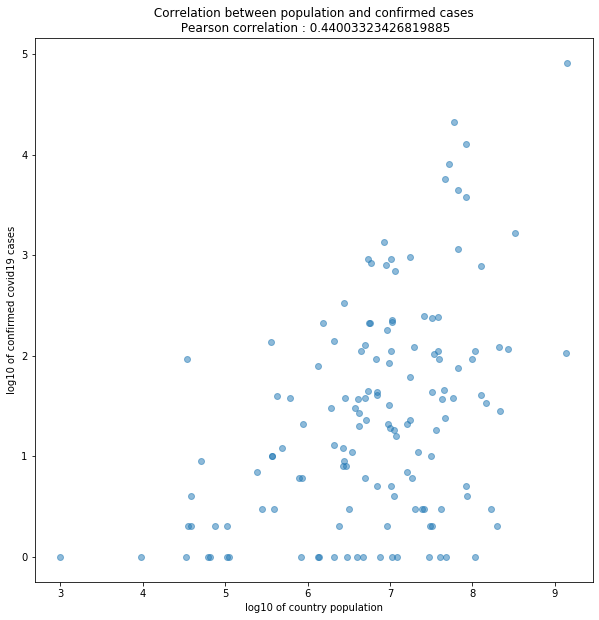

In [254]:
plt.figure(figsize=(10,10))
x = merged['pop_log']
y = merged['case_log'] 
plt.scatter(x,y, alpha = 0.5)
plt.xlabel('log10 of country population')
plt.ylabel('log10 of confirmed covid19 cases')

i = x[x.isin([np.nan, np.inf, -np.inf])].index
x =x.drop(i)
y = y.drop(i)

corr, _ = pearsonr(x,y)
plt.title(' Correlation between population and confirmed cases \n Pearson correlation : {}'.format(corr))
plt.show()

In [251]:
# x[~x.isin([np.nan, np.inf, -np.inf]).any(0)]


Int64Index([137], dtype='int64')

In [16]:
#checks if new countries have been added
# for country in df.columns:
#     if df.iloc[-2][country] == 0:
#         print(country)

In [193]:
# looking to see if there is a correlation between the average monthly temperatre of a country and the latest
# number of covid cases


import re
url2 = 'https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature'

all_temperatures = pd.read_html(url2)

def get_c(string):
#     print(string)
    string = re.sub(r'[^\x00-\x7F]+','-', string) # otherwise errors out on negative values
    return float(string[:string.find('(')])

In [197]:
country_temps = pd.DataFrame(columns = ['Country', 'temperature'])
for i in range(6): # cycles through all tables
    print(i)
    df_ = all_temperatures[i].iloc[:,[0,4]]
    df_['temperature'] = df_['Mar'].apply(get_c)
    del df_['Mar']
    df_ = df_.groupby('Country').mean()
    df_.reset_index(inplace=True)
    country_temps = country_temps.append(df_, ignore_index=True)
#     break


0
1
2
3
4
5


/home/eric/miniconda3/envs/geo_test/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [199]:
last_df = pd.DataFrame(df.iloc[-1])
last_df.reset_index(inplace=True)
last_df

,index,2020-03-15
0,China,81048.0
1,Afghanistan,10.0
2,Albania,38.0
3,Algeria,37.0
4,Andorra,2.0
...,...,...
139,United Kingdom,1144.0
140,United States,1678.0
141,Venezuela,2.0
142,Vietnam,53.0


In [200]:
merged_temp = country_temps.merge(last_df, left_on = 'Country',right_on = 'index', how='inner' )

# dropping china
i = merged_temp[merged_temp['Country']=='China'].index
merged_temp.drop(i, inplace=True)

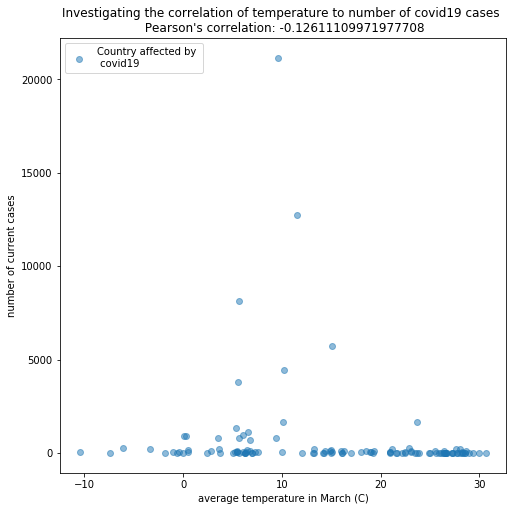

In [219]:
from scipy.stats import pearsonr

x = merged_temp['temperature']
y = merged_temp.iloc[:,-1]


# cov(X, Y) = (sum (x - mean(X)) * (y - mean(Y)) ) * 1/(n-1)

plt.figure(figsize=(8,8))
plt.scatter(x,y, alpha = 0.5, label='Country affected by \n covid19')
plt.xlabel('average temperature in March (C)')
plt.ylabel('number of current cases')
plt.title("Investigating the correlation of temperature to number of covid19 cases \n Pearson's correlation: {}".format(corr) )

corr, _ = pearsonr(x,y)
corr
plt.legend(loc='upper left')
plt.show()


-0.12611109971977708